# Пример использования модуля для сопоставления данных, полученных из реанализа ERA5 и данных с метеостанций

Задача: Данные реанализа требуется использовать при запуске волновой спектральной модели SWAN. Однако, данные реанализа могут отличаться от наблюдаемых в действительности метеопараметров. То есть необходимо провести сравнение с данными метеостанций и решить, какие поправочные коэффициенты вводить в модель или же вовсе отказаться от использования выбранного реанализа.

In [1]:
import os 

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm
from pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from meteotik.reanalysis import ERA5Processor

Для обработки реанализа ERA5 требуется инициализировать ERA5Processor. В качестве аргументов он примнимает

##### Аргументы
    folder - папка, в которой расположены файлы реанализа в формате netcdf;
    files - опционально. Можем указать списком какие именно файлы требуется обрабатывать. Если не указать, то будут обрабатываться все файлы в папке

In [2]:
rean_processor = ERA5Processor(folder='./data/era5')

Мы хотим посмотреть какой пространственный охват имеет данный реанализ. Для этого вызываем метод show_spatial_coverage, который нам покажет какие есть границы у охвата.

In [3]:
rean_processor.show_spatial_coverage()

"Lower left" corner: latitude - 50.79100036621094, longitude - 151.47000122070312
"Upper right" corner: latitude - 55.79100036621094, longitude - 167.7209930419922
The scope by latitude - 5.0
The scope by longitude - 16.250991821289062 



Можем посмотреть какие переменные есть в данном реанализе

In [4]:
rean_processor.print_variables()

Variables in netcdf file ['longitude', 'latitude', 'time', 'u10', 'v10']


Недостаточно наглядно? - Тогда мы можем нарисовать одно из полей. Мы можем выбрать конкретное поле или алгоритм выберет первое попавшееся 

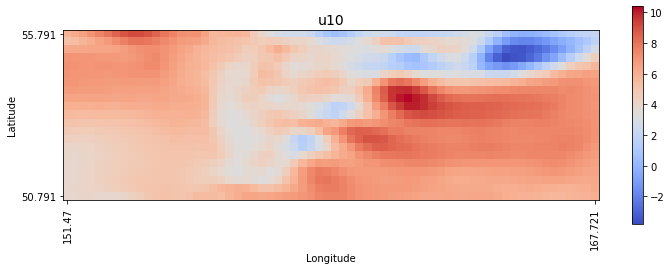

In [5]:
rean_processor.field_visualisation(variable='u10',
                                   file_to_vis='wind_bechevinski_2019-10-01.nc')

Для более красочных визуализаций в модуле предусмотрено использование библиотеки "plotly". Так, для просмотра анимаций можете использовать метод field_animation.

In [ ]:
rean_processor.field_animation(variable='u10')

Обратите внимание, при запуске этого метода через jupyter lab - интерактивная страница может не отобразиться - поэтому запускайте эту функцию, например, через PyCharm. 

## Формирование временного ряда из реанализа ERA5

Для выбранной точки (определяется по словарю с координатами) можем получить временной ряд. Координаты указывайте в тех же единицах, что используются в реанализе (в данном случае это географическая система координат WGS84).

В приведенном ниже примере используются координаты метеостанции "остров Беринга". Именно для этой точки формируется временной ряд из сетки реанализа.

In [6]:
dataframe = rean_processor.prepare_time_series(coordinates={'lat':55.2,'lon':165.98},
                                               change_time_step=False)

Processing... wind_bechevinski_2019-10-01.nc
Processing... wind_bechevinski_2019-11-01.nc


Алгоритм снимет значения U и V компонент с сетки, а также рассчитает значения скорости и направления ветра. Названия полученных столбцов будут иметь приставку "_reanalysis".

In [7]:
dataframe.head(3)

,U_reanalysis,V_reanalysis,Date,Velocity_reanalysis,Direction_reanalysis
0,-2.832589,-3.725541,2019-10-01 00:00:00,4.680087,37.246309
1,-3.106893,-2.987963,2019-10-01 01:00:00,4.310535,46.117883
2,-3.488509,-2.149553,2019-10-01 02:00:00,4.097593,58.359410


Существует возможность изменять дискретность временного ряда при помощи аргумента change_time_step. Хотите, например, суточную дискретность? - Используйте change_time_step=True и new_time_step='1D'.

Визуализация полученных временных рядов.

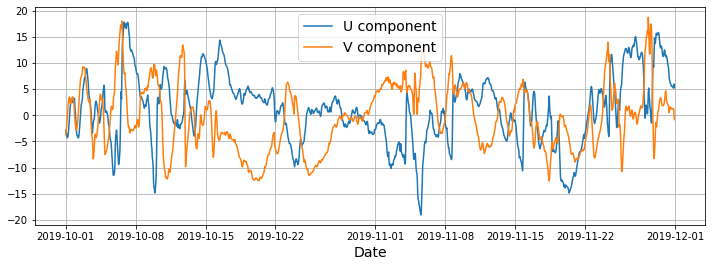

In [8]:
plt.plot(dataframe['Date'], dataframe['U_reanalysis'], label = 'U component')
plt.plot(dataframe['Date'], dataframe['V_reanalysis'], label = 'V component')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.show()

## Подготовка временного ряда с метеостанции

В данном случае использовались данные [РОСГИДРОМЕТ'а](http://meteo.ru/data) (см. [раздел](http://meteo.ru/data/163-basic-parameters)). Для эффективной обработки данных с метеостанций необходимо инициализировать класс MeteoMStation.

In [9]:
from meteotik.meteo import MeteoMStation

Читаем датафрейм с данными метеопараметров, полученных с соседней метеостанции.

In [10]:
data_bering = pd.read_csv('./data/meteostations/bering.txt', sep=";", 
                          names=['Station_id','Year','Month','Day', 'Time','Direction','Velocity'])
data_bering.head(3)

,Station_id,Year,Month,Day,Time,Direction,Velocity
0,32618,2009,1,1,0,65,8
1,32618,2009,1,1,3,70,8
2,32618,2009,1,1,6,65,6


У каждоого поставщика гидрометеорологиечской информации есть определенные стандарты формирования таблиц с данными. В конкретном случае есть необходимость перевести несколько столбцов с датой и временем в один. Сделаем это.

##### Аргументы
    year_col - название столбца, в котором содержатся годы
    month_col - название столбца, в котором содержатся месяца
    day_col - название столбца, в котором содержатся дни
    hour_col - название столбца, в котором содержатся часы

In [11]:
station_processor = MeteoMStation(data_bering)
data_bering['Date'] = station_processor.prepare_datetime_column(year_col='Year', 
                                                                month_col='Month',
                                                                day_col='Day', 
                                                                hour_col='Time')

В модуле есть возможность производить отрисовку графика "роза ветров", где цветом показана средняя скорость ветра для заданного направления. Для этого нужно воспользоваться функцией plot_wind_rose.

##### Аргументы
    dataframe - pandas датафрейм с данными
    vel_col - название столбца, в котором содержится скорость ветра
    direction_col - название столбца, в котором содержится направление ветра

Percentage of observations with calm 1.2%


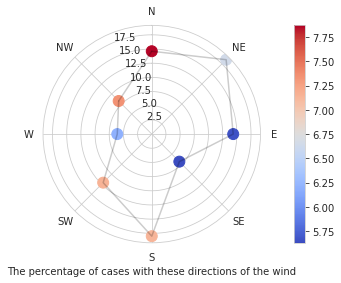

In [13]:
from meteotik.analysis import plot_wind_rose

plot_wind_rose(dataframe = data_bering, 
               vel_col='Velocity',
               direction_col='Direction')

### Расчет U и V компонент из скорости и направления ветра

Теперь в данных есть столбец с датой и временем, но не хватает столбцов с компонентами U и V. - Не проблема, их можно рассчитать при помощи метода calculate_uv. Нужно лишь указать названия столбцов, содержащих данные о скорости ветра (vel_col) и его направлении (direction_col).

##### Аргументы
    vel_col - название столбца, в котором содержится скорость ветра
    direction_col - название столбца, в котором содержится направление ветра

In [14]:
u_arr, v_arr = station_processor.calculate_uv(vel_col='Velocity',
                                              direction_col='Direction')

data_bering['U_meteo'] = u_arr
data_bering['V_meteo'] = v_arr

Для того, чтобы проверить правильно ли был произведен рассчет U и V компонент из исходных наблюдений, можно воспользоваться методом check_correctness. Алгоритм возьмет исходные значения скорости и направления ветра - конвертирует их в U и V компоненты. Затем производится обратное преобразование - U и V компоненты преобразуются в скорость и направление. Если исходные и восстановленные метеопараметры не отличаются, то все хорошо.

##### Аргументы
    vel_col - название столбца, в котором содержится скорость ветра
    direction_col - название столбца, в котором содержится направление ветра
    date_col - название столбца, в котором содержится datetime данные
    
Для более корректных расчетов можно удалить все строчки в датафрейме, где был зафиксирован штиль (румб равен 0) - тогда исходные и восстановленные ряды должны друг друга повторять.

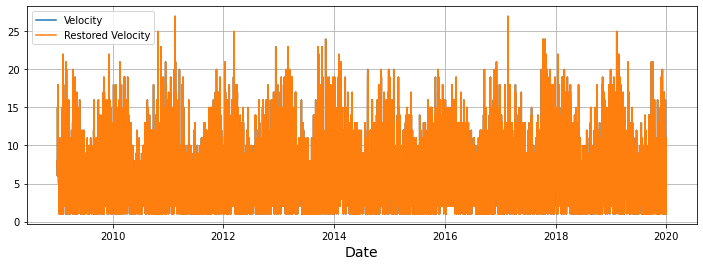

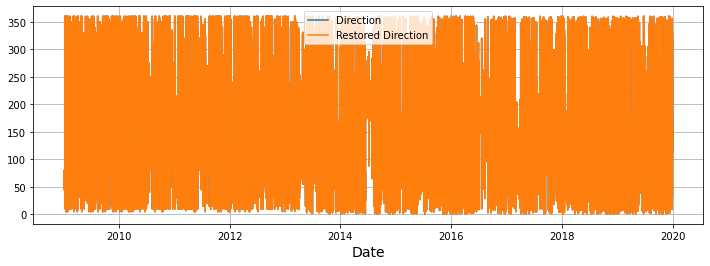

In [20]:
# Уберем все значения со штилем
data_bering['Direction'] = data_bering['Direction'].replace(0, np.nan)
data_bering.dropna(inplace=True)

# Запускаем алгорит проверки
station_processor = MeteoMStation(data_bering)
station_processor.check_correctness(vel_col='Velocity',
                                    direction_col='Direction',
                                    date_col='Date')

Да, действительно, преобразования выполняются корректно - можно прожолжать работу.

### Сопоставление по срокам наблюдений

Из приведенных выше кусочков датафреймов видно, что у данных с метеостанции наблюдения разнесены по срокам, в то время как данные реанализа ежечасные. Приведем датафреймы к единому виду.

##### Аргументы
    dataframe_left - датафрейм для "уравнивания"
    dataframe_right - датафрейм для "уравнивания"
    merge_column - название колонки, по которой будет производиться слияние

In [21]:
from meteotik.analysis import equal_mapping

meteo_df, rean_df = equal_mapping(dataframe_left=data_bering, 
                                  dataframe_right=dataframe,
                                  merge_column='Date')

In [22]:
meteo_df.head(2)

,Station_id,Year,Month,Day,Time,Direction,Velocity,Date,U_meteo,V_meteo
0,32618,2019,10,1,0,42.0,5,2019-10-01 00:00:00,-3.345653,-3.715724
1,32618,2019,10,1,3,80.0,3,2019-10-01 03:00:00,-2.954423,-0.520945


In [23]:
rean_df.head(2)

,U_reanalysis,V_reanalysis,Date,Velocity_reanalysis,Direction_reanalysis
0,-2.832589,-3.725541,2019-10-01 00:00:00,4.680087,37.246309
1,-3.996123,-1.122849,2019-10-01 03:00:00,4.150878,74.305458


Теперь мы видим, что для датафрейма, сформированного из ERA5 остались только срочные наблюдения, что позволяет нам теперь провести сравнение с метеостанцией.

## Сравнение временных рядов

Сначала посмотрим на простые статистики - коэффициент корреляции, смещение и среднюю абсолютную ошибку. 

Для этого воспользуемся функцией print_statistics. Возьмем за правило, что "левый датафрейм" - это данные с метеостанции, а "правый датафрейм" - это данные реанализа. 

columns_for_compare - это словарь, где ключ, это столбец из "левого датафрейма", который требуется сравнить с ключом - столбцом из "правого датафрейма".

In [24]:
from meteotik.analysis import print_statistics

print_statistics(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U_meteo':'U_reanalysis', 
                                        'V_meteo':'V_reanalysis',
                                        'Velocity':'Velocity_reanalysis'})

Bias for U_meteo vs U_reanalysis: 0.17
MAE for U_meteo vs U_reanalysis: 2.15
Pearson correlation coefficient for U_meteo vs U_reanalysis: 0.92


Bias for V_meteo vs V_reanalysis: -0.53
MAE for V_meteo vs V_reanalysis: 2.06
Pearson correlation coefficient for V_meteo vs V_reanalysis: 0.91


Bias for Velocity vs Velocity_reanalysis: 1.74
MAE for Velocity vs Velocity_reanalysis: 2.19
Pearson correlation coefficient for Velocity vs Velocity_reanalysis: 0.86




Иногда возникает необходимость произвести сравнение не на всей выборке, а на некоторой "важной" её части. Например, нас могут интересовать как соотносятся значения на реанализе и на метеостанции для высоких (больше 75го квантиля) значениях скоростей ветра.

Для этого в функции "print_statistics" есть аргумент check_peaks. Посмотрим:

In [25]:
print_statistics(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'Velocity':'Velocity_reanalysis'},
                 check_peaks = True)

Bias for Velocity vs Velocity_reanalysis: 1.74
MAE for Velocity vs Velocity_reanalysis: 2.19
Pearson correlation coefficient for Velocity vs Velocity_reanalysis: 0.86
(Peak) Bias for Velocity vs Velocity_reanalysis: 0.62
(Peak) MAE for Velocity vs Velocity_reanalysis: 1.64
(Peak) Pearson correlation coefficient for Velocity vs Velocity_reanalysis: 0.65




Таким образом мы видим, что на больших значениях скорости ветра данные соотносятся несколько хуже. 

Но смотреть на цифры слишком скучно - нарисуем графики!

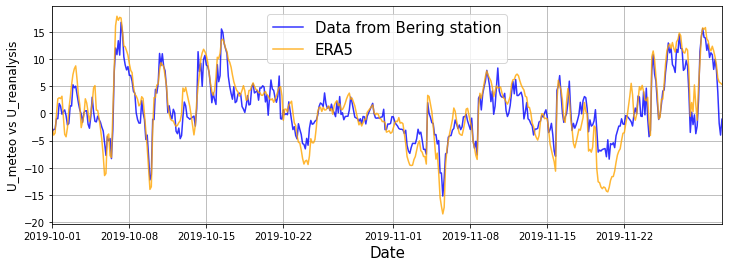

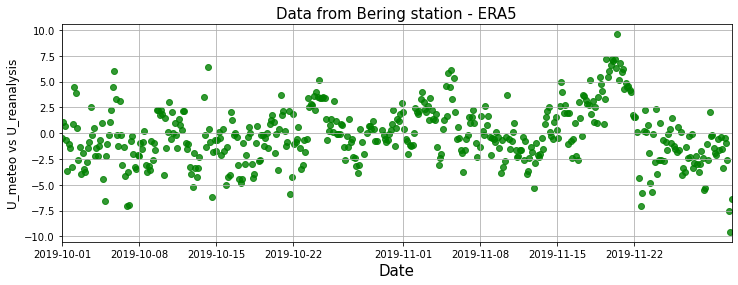

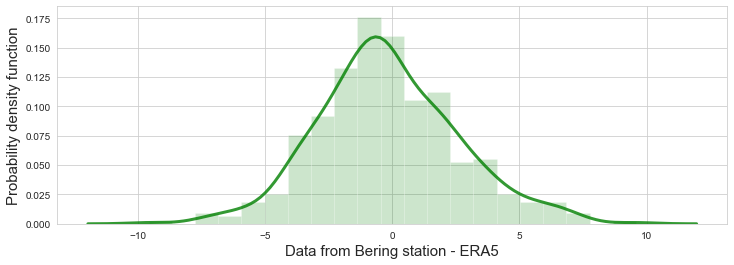

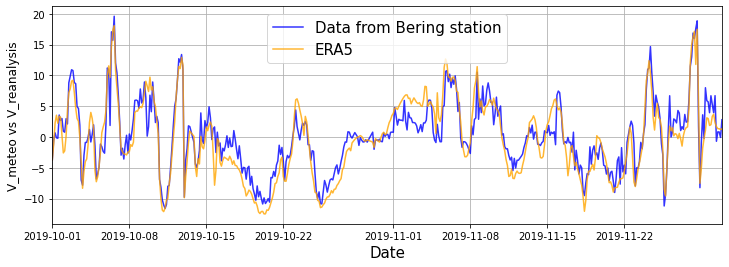

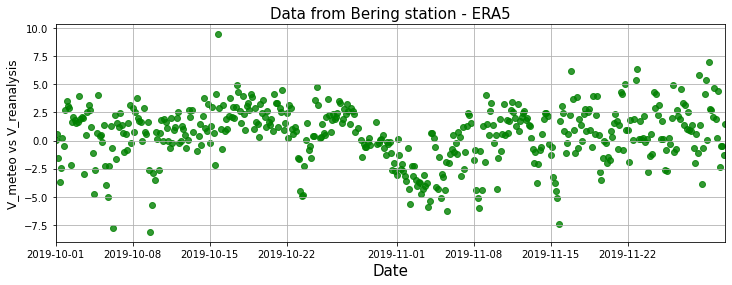

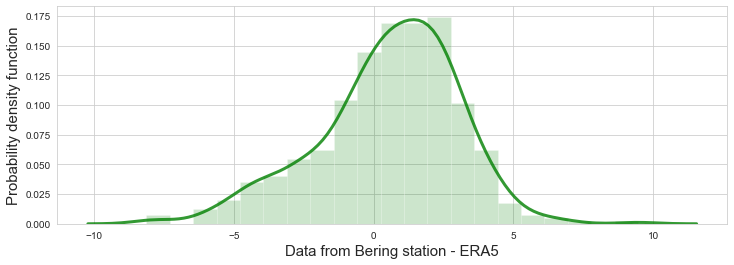

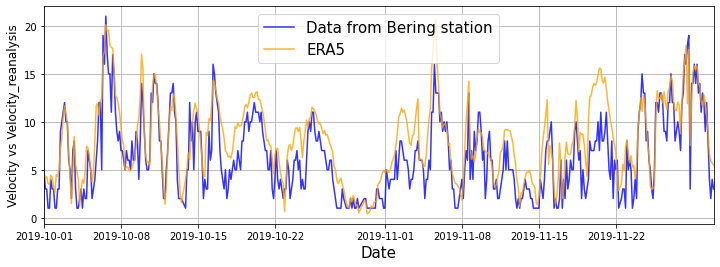

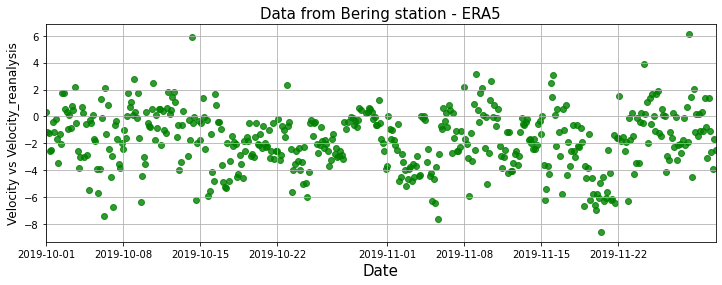

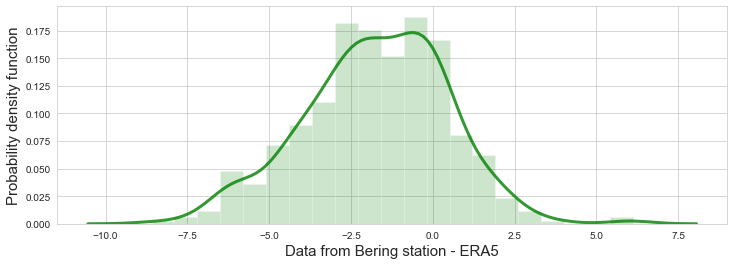

In [26]:
from meteotik.analysis import make_visual_comparison

make_visual_comparison(dataframe_left = meteo_df,
                       dataframe_right = rean_df,
                       columns_for_compare = {'U_meteo':'U_reanalysis', 
                                              'V_meteo':'V_reanalysis',
                                              'Velocity':'Velocity_reanalysis'},
                       dataframe_labels = ['Data from Bering station', 'ERA5'])

Подробнее разберем какие графики формируются. По три графика на каждый параметр. 

* Первый - временные ряды для наглядного сопоставления;
* Второй - точечная диаграмма, где показана разность двух векторов. В названии указано что из чего вычетается;
* Третий - ядерная оценка плотности, т.е. другое представление данных из графика номер 2.

Также есть возможность построить квантильные биплоты для сравнения.

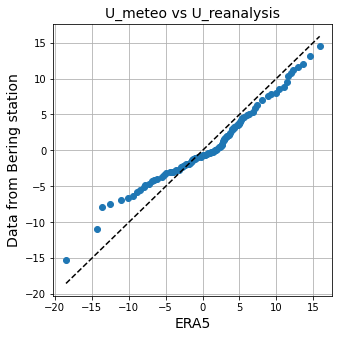

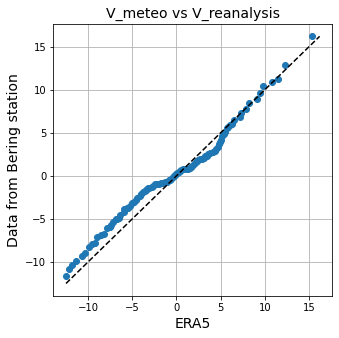

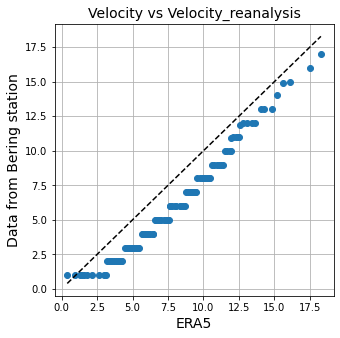

In [27]:
from meteotik.analysis import qq_comparison
rcParams['figure.figsize'] = 5, 5

qq_comparison(dataframe_left = meteo_df,
              dataframe_right = rean_df,
              columns_for_compare = {'U_meteo':'U_reanalysis', 
                                     'V_meteo':'V_reanalysis',
                                     'Velocity':'Velocity_reanalysis'},
              dataframe_labels = ['Data from Bering station', 'ERA5'])

### Составление сводных таблиц

Для упрощения анализа имеет смысл сводить метрики в таблицы, так проще будет проводить сравнения.

In [28]:
from meteotik.analysis import make_report

df = make_report(dataframe_left = meteo_df,
                 dataframe_right = rean_df,
                 columns_for_compare = {'U_meteo':'U_reanalysis', 
                                        'V_meteo':'V_reanalysis',
                                        'Velocity':'Velocity_reanalysis'},
                 check_peaks = True)

df

,Variables,Bias,MAE,Correlation
0,U_meteo vs U_reanalysis,0.165013,2.152714,0.918627
1,(Peak) U_meteo vs U_reanalysis,0.842678,1.742114,0.852994
2,V_meteo vs V_reanalysis,-0.530330,2.056063,0.914950
3,(Peak) V_meteo vs V_reanalysis,-0.923172,1.919522,0.845101
4,Velocity vs Velocity_reanalysis,1.743873,2.192392,0.855505
5,(Peak) Velocity vs Velocity_reanalysis,0.621689,1.642624,0.647929
